In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
import pickle
import pyprind
import re
from PIL import Image
from IPython.core.display import Image as img
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, ImageColorGenerator
import math
from prettytable import PrettyTable as PT

In [2]:
PATH_DATA = "V:/Programmazione/Amazon/"

In [3]:
df = pd.read_pickle("%sAmazonDataProject.pkl" % PATH_DATA)

# Deletion of stopwords from reviews' bodies and headlines

In [4]:
STOPWORDS = set(stopwords.words('english')).union([u'br'])

In [5]:
"""
Given a the list of reviews the function return a list which contain all the words of the reviews which:
1. are not stopwords
2. contain only letters
"""
def deleteStopwords(text):
    text = nltk.word_tokenize(text)
    res = []
    for t in text:
        t = t.lower()
        if not bool(re.search(r"[^A-Za-z]", t)) and t not in STOPWORDS:
            res.append(t)
    return res

In [6]:
try:
    df_reviews = pd.read_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA)
except:
    df_reviews = df.filter(["review_id","review_headline","review_body"], axis=1)
    df_reviews["review_headline"] = df_reviews["review_headline"].apply(func = deleteStopwords)
    df_reviews["review_body"] = df_reviews["review_body"].apply(func = deleteStopwords)
    df_reviews.to_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA)

## Construction of "large" documents divided by categories/star ratings, body/headlines.

### Categories

In [7]:
categories = sorted(df.product_category.unique().tolist())
print(", ".join(categories))

Apparel, Automotive, Baby, Beauty, Books, Camera, Digital_Ebook_Purchase, Digital_Music_Purchase, Digital_Video_Download, Electronics, Health & Personal Care, Home, Home Entertainment, Home Improvement, Kitchen, Lawn and Garden, Luggage, Mobile_Apps, Music, Musical Instruments, Office Products, PC, Personal_Care_Appliances, Pet Products, Shoes, Software, Sports, Toys, Video, Video DVD, Video Games, Watches, Wireless


### Large document of categories' bodies

In [8]:
categories_reviews = dict()
all_reviews_without_stopwords = []
for c in categories:
    categories_reviews[c] = []
    for index,row in df[df.product_category==c].iterrows():
        categories_reviews[c]+= df_reviews.loc[index].review_body
    all_reviews_without_stopwords+=categories_reviews[c]

### Large document of categories' headlines

In [9]:
categories_reviews_headlines = dict()
for c in categories:
    categories_reviews_headlines[c] = []
    for index,row in df[df.product_category==c].iterrows():
        categories_reviews_headlines[c]+=df_reviews.loc[index].review_headline
    all_reviews_without_stopwords+=categories_reviews_headlines[c]

### Large document of star ratings' bodies

In [10]:
stars_body = dict()
for i in range(1,6):
    stars_body[i] = []
    for index,row in df[df.star_rating==i].iterrows():
        stars_body[i]+=df_reviews.loc[index].review_body

### Large document of star ratings' headlines

In [11]:
stars_head = dict()
for i in range(1,6):
    stars_head[i] = []
    for index,row in df[df.star_rating==i].iterrows():
        stars_head[i]+=df_reviews.loc[index].review_headline

# Stats on the text

### Number of reviews

In [12]:
t = PT(['Category', 'Number of reviews','% respect to the total'])
tot = float(df.count()[0])
for c in categories:
    count = df[df.product_category==c].count()[0]
    t.add_row([c,count,"%.4f%%" % (count/tot*100)])
t.align["Category"] = 'l'
print("Number of total reviews = %.0f" % tot)
print(t)

Number of total reviews = 1705765
+--------------------------+-------------------+------------------------+
| Category                 | Number of reviews | % respect to the total |
+--------------------------+-------------------+------------------------+
| Apparel                  |         2         |        0.0001%         |
| Automotive               |        530        |        0.0311%         |
| Baby                     |        4328       |        0.2537%         |
| Beauty                   |         2         |        0.0001%         |
| Books                    |       257793      |        15.1130%        |
| Camera                   |        6427       |        0.3768%         |
| Digital_Ebook_Purchase   |       289111      |        16.9491%        |
| Digital_Music_Purchase   |       29263       |        1.7155%         |
| Digital_Video_Download   |       31420       |        1.8420%         |
| Electronics              |        5846       |        0.3427%         |
| He

In [13]:
t = PT(['Stars', 'Number of reviews','% respect to the total'])
for i in range(1,6):
    count = df[df.star_rating==i].count()[0]
    t.add_row([i,count,"%.4f%%" % (count/tot*100)])
print("Number of total reviews = %.0f" % tot)
print(t)

Number of total reviews = 1705765
+-------+-------------------+------------------------+
| Stars | Number of reviews | % respect to the total |
+-------+-------------------+------------------------+
|   1   |       84473       |        4.9522%         |
|   2   |       59070       |        3.4630%         |
|   3   |       125657      |        7.3666%         |
|   4   |       291570      |        17.0932%        |
|   5   |      1144995      |        67.1250%        |
+-------+-------------------+------------------------+


## Words Counts

### Categories' table

In [14]:
t = PT(['Category', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
tot = 0
for c in categories:
    body_tot = len(nltk.word_tokenize(" ".join(df[df.product_category==c].review_body.tolist())))
    body_stop = len(categories_reviews[c])
    head_tot = len(nltk.word_tokenize(" ".join(df[df.product_category==c].review_headline.tolist())))
    head_stop = len(categories_reviews_headlines[c])
    t.add_row([c,
               body_tot,
               body_stop,
               "%.4f%%" % ((body_tot-body_stop)/float(body_tot)*100),
               head_tot,
               head_stop,
               "%.4f%%" % ((head_tot-head_stop)/float(head_tot)*100),
              ])
    tot+=body_tot+head_tot
print("Number of words (headline+body) of all reviews = %d, without stopwrods =%d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),(tot-len(all_reviews_without_stopwords))/float(tot)*100))
t.align["Category"] = 'l'
print(t)

Number of words (headline+body) of all reviews = 140292840, without stopwrods =58658385, % deleted = 58.19%
+--------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Category                 |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+--------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Apparel                  |    59    |       25       |  57.6271%  |    5     |         3          |    40.0000%    |
| Automotive               |  21114   |      9069      |  57.0475%  |   2015   |        1300        |    35.4839%    |
| Baby                     |  247906  |     101372     |  59.1087%  |  17989   |       10776        |    40.0967%    |
| Beauty                   |   1026   |      450       |  56.1404%  |    6     |         4          |    33.3333%    |
| Books                    | 28753673 |    11604673    |  5

### Rating stars' table

In [15]:
t = PT(['Stars', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
for i in range(1,6):
    body_tot = len(nltk.word_tokenize(" ".join(df[df.star_rating==i].review_body.tolist())))
    body_stop = len(stars_body[i])
    head_tot = len(nltk.word_tokenize(" ".join(df[df.star_rating==i].review_headline.tolist())))
    head_stop = len(stars_head[i])
    t.add_row([c,
               body_tot,
               body_stop,
               "%.4f%%" % ((body_tot-body_stop)/body_tot*100),
               head_tot,
               head_stop,
               "%.4f%%" % ((head_tot-head_stop)/head_tot*100),
              ])
print("Number of words (headline+body) of all reviews = %d, without stopwrods =%d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),(tot-len(all_reviews_without_stopwords))/float(tot)*100))
print(t)

Number of words (headline+body) of all reviews = 140292840, without stopwrods =58658385, % deleted = 58.19%
+----------+----------+----------------+------------+----------+--------------------+----------------+
|  Stars   |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+----------+----------+----------------+------------+----------+--------------------+----------------+
| Wireless | 7880943  |    3133815     |  0.0000%   |  390427  |       208001       |    0.0000%     |
| Wireless | 7246807  |    2890271     |  0.0000%   |  281983  |       148593       |    0.0000%     |
| Wireless | 13803739 |    5534045     |  0.0000%   |  588380  |       322719       |    0.0000%     |
| Wireless | 28094095 |    11462101    |  0.0000%   | 1235007  |       745856       |    0.0000%     |
| Wireless | 76363904 |    31477394    |  0.0000%   | 4407614  |      2735590       |    0.0000%     |
+----------+----------+----------------+------------+----------+----

### Categories' graphs

In [16]:
def plotFreq(list_words,subplot_column,title):
    fr = nltk.FreqDist(list_words)
    plt.subplot(1, 2, subplot_column)
    plt.rcParams["figure.figsize"] = (8, 16)
    plt.title(title, fontsize = 15)
    fr.plot(30)

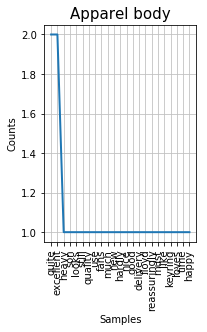

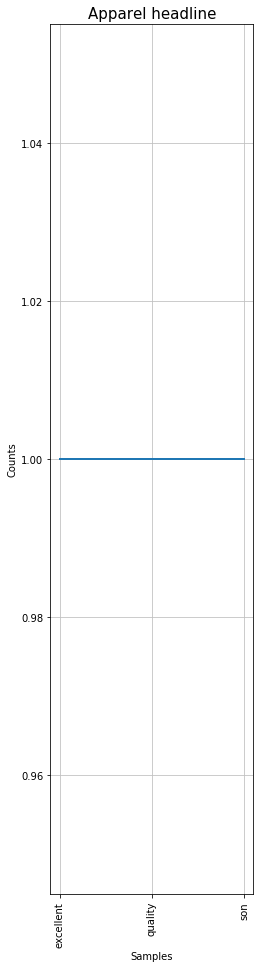

In [17]:
for c in categories:
    plotFreq(categories_reviews[c],1,"%s body" % c)
    plotFreq(categories_reviews_headlines[c],2,"%s headline" % c)
    plt.show()
    break

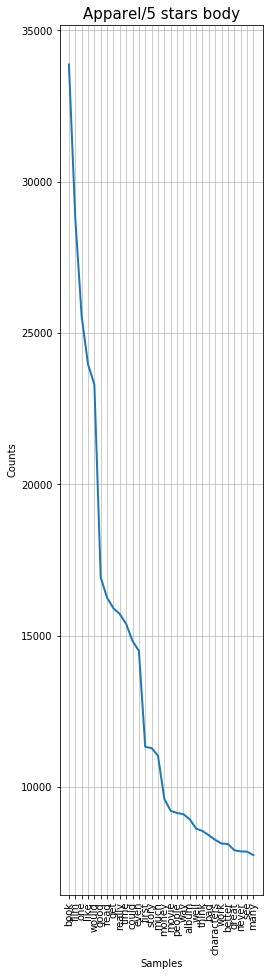

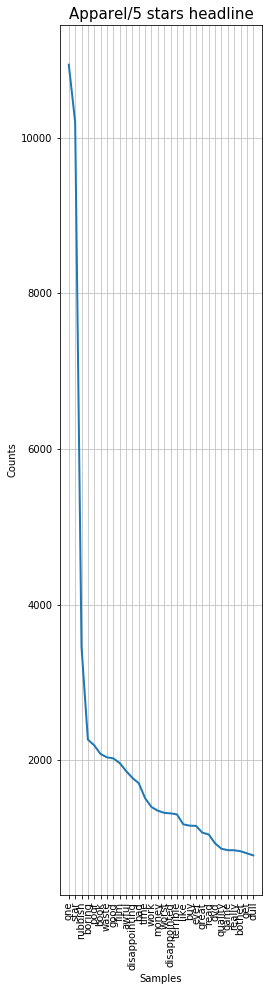

In [19]:
for i in range(1,6):
    plotFreq(stars_body[i],1,"%s/5 stars body" % c)
    plotFreq(stars_head[i],2,"%s/5 stars headline" % c)
    plt.show()
    break

### Lexical diversity

In [20]:
def lexical_diversity(text):
    return len(text)/len(set(text))

In [21]:
t = PT(['Category', 'Body', 'Headline'])
for c in categories:
    t.add_row([c,lexical_diversity(categories_reviews[c]),lexical_diversity(categories_reviews_headlines[c])])
t.align["Category"] = 'l'
print(t)

+--------------------------+------+----------+
| Category                 | Body | Headline |
+--------------------------+------+----------+
| Apparel                  |  1   |    1     |
| Automotive               |  4   |    3     |
| Baby                     |  14  |    6     |
| Beauty                   |  1   |    1     |
| Books                    |  93  |    25    |
| Camera                   |  17  |    7     |
| Digital_Ebook_Purchase   |  86  |    32    |
| Digital_Music_Purchase   |  22  |    9     |
| Digital_Video_Download   |  17  |    11    |
| Electronics              |  16  |    6     |
| Health & Personal Care   |  3   |    2     |
| Home                     |  7   |    4     |
| Home Entertainment       |  2   |    1     |
| Home Improvement         |  5   |    3     |
| Kitchen                  |  1   |    1     |
| Lawn and Garden          |  2   |    1     |
| Luggage                  |  1   |    1     |
| Mobile_Apps              |  64  |    25    |
| Music      

## Collocations

In [22]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = BigramCollocationFinder.from_words(all_reviews_without_stopwords)
finder2.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
res2 = finder2.nbest(bigram_measures.pmi, 10)
print("TOP BIGRAMS: %s" % ", ",join([" ".join(r) for r in res2]))

NameError: name 'join' is not defined

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = TrigramCollocationFinder.from_words(all_reviews_without_stopwords)
finder3.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
res3 = finder3.nbest(trigram_measures.pmi, 10)
print("TOP TRIGRAMS: %s" % ", ",join([" ".join(r) for r in res3]))

In [ ]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd','4th'])
for c in categories:
    finder = BigramCollocationFinder.from_words(categories_reviews[c]+categories_reviews_headlines[c])
    finder.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
    res = finder.nbest(bigram_measures.pmi, 4)
    for _ in range(4 - len(res)): res.append("")
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2],res[3]])
t.align["Category"] = 'l'
print(t)

In [ ]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd'])
for c in categories:
    finder3 = TrigramCollocationFinder.from_words(categories_reviews[c])
    finder3.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
    res = finder3.nbest(trigram_measures.pmi, 3)
    for _ in range(3 - len(res)): res.append("")
    res = [" ".join(r) for r in res]
    t.add_row([c,res[0],res[1],res[2]])
t.align["Category"] = 'l'
print(t)

# Words

# Common words vs TF_IDF

### Calculations of most common words 

Draw wordlcloud taking into account all the categories (body+headline)

In [ ]:
freq = nltk.FreqDist(all_reviews_without_stopwords)
make_word_cloud({v:k for v,k in freq.most_common(300)}, max_words = n, title = "Most common word taking into account all categories together", mask_path = "ImagesWordClouds/amazon.jpg")
plt.show()

### Calculation of most important words based on the TF-IDF for each category

In [ ]:
def tfIdf(fdistList):
    N_DOCUMENTS = len(fdistList)
    print("Total number of documents = %d" % N_DOCUMENTS)
    vocab = set()
    print("I'm creating the dictionary")
    for fdist in fdistList.values():
        vocab = vocab.union(set(fdist.keys()))#all words presents in all the documents
    idf = dict()
    print("I'm calculating the IDF")
    for word in vocab:
        count = 0.0
        for fdist in fdistList.values():
            if(word in fdist):
                count+=1
        idf[word] = math.log(N_DOCUMENTS/count)
    listTfIdf = dict()
    print("I'm calculating the tf-idf")
    i = 0
    for title, fdist in fdistList.items():
        listTfIdf[title] = dict()
        n_token_document = float(sum(fdist.values()))
        for word in fdist:
            listTfIdf[title][word] = fdist[word] * idf[word] /  n_token_document
        i+=1
    print("I have finished")
    return listTfIdf

In [ ]:
listTfIdf_categories = tfIdf(freq_dist_categories)

### Differences between Most common and TF-IDF words

word_cloud function

In [ ]:
#Function to draw the wordcloud
def make_word_cloud(dictWords, mask_path=None, background_color = "white", max_words = 2000, title = "", mux = 1, subplots_params = (1,1,1)):
    if(max_words>len(dictWords)):
        max_words = len(dictWords)
    topK = sorted(dictWords.iteritems(), key = lambda (k, v): (v, k), reverse = True)[:max_words]
    text =[] 
    for word, value in topK:
        text+=[word]*int(round(value*mux))
    text = " ".join(text)
    if(mask_path!=None):
        # read the mask image
        mask = np.array(Image.open(mask_path))
        wc = WordCloud(background_color = background_color, max_words = max_words,  mask = mask, stopwords = None, collocations = False, max_font_size = 120)
        
    else:
        wc = WordCloud(background_color = background_color, max_words = max_words, stopwords = None, collocations = False, max_font_size = 120)
    # generate word cloud
    wc.generate(text)
    if(mask_path!=None):
        wc.recolor(color_func=ImageColorGenerator(mask))
    # store to file
    plt.subplot(subplots_params[0], subplots_params[1], subplots_params[2])
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.title(title, fontsize = 15)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis("off")

Print the differences between them

In [ ]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud({v:k for v,k in freq_dist_categories[c].most_common(n)}, max_words = n, title = "Most common words in %s" % c, mask_path = "ImagesWordClouds/%s.jpg" % c,subplots_params=(1,2,1))
    make_word_cloud(listTfIdf_categories[c], max_words = n, title = "TF-IDF words in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2))
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## TF-IDF body vs TF-IDF headline

In [ ]:
freq_dist_categories_headlines = dict()
for c in pyprind.prog_bar(categories):
    freq_dist_categories_headlines[c] = nltk.FreqDist(categories_reviews_headlines[c])

In [ ]:
listTfIdf_headlines = tfIdf(freq_dist_categories_headlines)

In [ ]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud(listTfIdf_categories[c], max_words = n, title = "TF-IDF body in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,1))
    make_word_cloud(listTfIdf_headlines[c], max_words = n, title = "TF-IDF headlline in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2))
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## Words based on the star_rating

We expect to find words which has a sentiment value based on the star rating. For example, for the reviews of 1 start, we expect to find: "bad, worst..". Moreover, we forcast to have better more interesting results using the most common words approach compare to the tf-idf.

### Looking at the reviews' body

In [ ]:
freq_dist_stars_body = dict()
for i in range(1,6):
    freq_dist_stars_body[i] = nltk.FreqDist(stars_body[i])

In [ ]:
listTfIdf_stars_body = tfIdf(freq_dist_stars_body)

In [ ]:
mux = len(all_reviews_without_stopwords) 
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars_body[i], max_words = n, title = "TF-IDF body in %d /5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

In [ ]:
n = 200
for i in range(1,6):
    make_word_cloud({v:k for v,k in freq_dist_stars_body[i].most_common(n)}, max_words = n, title = "Most common words body in %d /5 stars" % i, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

### Looking at the reviews' headline

In [ ]:
freq_dist_stars_head = dict()
for i in range(1,6):
    freq_dist_stars_head[i] = nltk.FreqDist(stars_head[i])

In [ ]:
listTfIdf_stars_head = tfIdf(freq_dist_stars_head)

In [ ]:
mux = len(all_reviews_without_stopwords) 
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars_head[i], max_words = n, title = "TF-IDF headline in %d /5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

In [ ]:
n = 200
for i in range(1,6):
    make_word_cloud({v:k for v,k in freq_dist_stars_head[i].most_common(n)}, max_words = n, title = "Most common words headline in %d /5 stars" % i, mask_path = "ImagesWordClouds/%dstars.jpg" % i)
    plt.show()

### Conclusions

It seems it is far better to look at the headline to catch the "sentiment" of the reviews.

# Sentiment analysis